In [1]:
import sys
import os

import numpy as np
import pandas as pd
import mayavi.mlab as mlab

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import matplotlib.patches as mpatches
from matplotlib.cm import get_cmap


import gdist

sys.path.append("..")
from util.surface import Surface
from util.contacts import Contacts
from util.sim import create_n_patches, remap, simulate_one, gain_matrix_dipole_verts, generate_noise
from util.geometry import create_part


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib.patches import Rectangle
import itertools


def scale_bars(ax, pos, sizex=None, labelx=None, sizey=None, labely=None, barwidth=4, fontsize=14,
               config=3):
    """
    Configurations:    
          9
       _  _   _
    2 |        | 1
    
    6 |        | 7
    
    3 |_  _   _| 4    
          8
    """
    
    if config not in [1, 2, 3, 4, 6, 7, 8, 9]:
        config = {"upper right": 1, "upper left": 2, "lower left": 3, "lower right": 4,
                  "left": 6, "right": 7, "bottom": 8, "top": 9}[config]
    
    if ((sizex is not None) and (config in [6, 7])) or ((sizey is not None) and (config in [8, 9])):
        raise ValueError(f"Invalid combination of sizex/sizey and config")
    
    
    if sizex:
        sizex_ax = ax.transLimits.transform((sizex, 0))[0] - ax.transLimits.transform((0, 0))[0]
        if config in [2, 3]:
            xbarpos = pos
        elif config in [8, 9]:
            xbarpos = (pos[0] - 0.5*sizex_ax, pos[1])
        else:
            xbarpos = (pos[0] - sizex_ax, pos[1])

        ax.add_artist(Rectangle(xbarpos, sizex_ax, 0, lw=barwidth, ec='black', transform=ax.transAxes))
        if labelx:
            offset, va = (-0.5*fontsize, 'top') if config in [3, 4, 8] else (0.4*fontsize, 'bottom')
            ax.annotate(labelx, xy=(xbarpos[0] + 0.5*sizex_ax, xbarpos[1]), xycoords='axes fraction',
                        xytext=(0, offset), textcoords='offset points', ha='center', va=va, fontsize=fontsize)
            
    if sizey:
        sizey_ax = ax.transLimits.transform((0, sizey))[1] - ax.transLimits.transform((0, 0))[1]
        if config in [3, 4]:
            ybarpos = pos
        elif config in [6, 7]:
            ybarpos = (pos[0], pos[1] - 0.5*sizey_ax)
        else:
            ybarpos = (pos[0], pos[1] - sizey_ax)
        ax.add_artist(Rectangle(ybarpos, 0, sizey_ax, lw=barwidth, ec='black', transform=ax.transAxes))
        if labely:
            offset, ha = (-0.5*fontsize, 'right') if config in [2, 3, 6] else (0.5*fontsize, 'left')
            ax.annotate(labely, xy=(ybarpos[0], ybarpos[1] + 0.5*sizey_ax), xycoords='axes fraction',
                        xytext=(offset, 0), textcoords='offset points', ha=ha, va='center', fontsize=fontsize)

            
def add_panel_letters(fig, axes=None, fontsize=30, xpos=-0.04, ypos=1.05):
    labels = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    
    if axes is None:
        axes = fig.get_axes()

    if type(xpos) == float:
        xpos = itertools.repeat(xpos)
    if type(ypos) == float:
        ypos = itertools.repeat(ypos)

    for i, (ax, x, y) in enumerate(zip(axes, xpos, ypos)):
        ax.text(x, y, labels[i],
                transform=ax.transAxes, size=fontsize, weight='bold')   

In [3]:
def plot_brain(surf, contacts, surf_sz, scalars, cmap, interactive=False, 
               highlight_contacts=None, highlight_sources=None):
    mlab.figure(bgcolor=(1,1,1), size=(1800, 1800))

    # Glass brain
    mlab.triangular_mesh(surf.vertices[:, 0], surf.vertices[:, 1], surf.vertices[:, 2], surf.triangles,
                         color=(0.5, 0.5, 0.5), representation='surface', opacity=0.03)

    # Electrodes
    # mlab.points3d(contacts.xyz[:, 0], contacts.xyz[:, 1], contacts.xyz[:, 2], color=(0, 0.4, 0), scale_factor=2)
    mlab.points3d(contacts.xyz[:, 0], contacts.xyz[:, 1], contacts.xyz[:, 2], color=(0.4, 0.6, 1), scale_factor=2.5)
    
    if highlight_contacts is not None:
        inds = [contacts.names.index(c) for c in highlight_contacts]
        mlab.points3d(contacts.xyz[inds, 0], contacts.xyz[inds, 1], contacts.xyz[inds, 2],
                      # color=(1, 1, 0),
                      color=(0.3, 1.0, 0.3),
                      scale_factor=2.5)
        
    if highlight_sources is not None:
        inds = highlight_sources
        mlab.points3d(surf_sz.vertices[inds, 0], surf_sz.vertices[inds, 1], surf_sz.vertices[inds, 2],
                      # color=(1, 1, 0),
                      color=(0.3, 1.0, 0.3),
                      scale_factor=4, line_width=8, mode='2dcross')
        
#     for i, (elec, inds) in enumerate(contacts.electrodes.items()):
#         mlab.text3d(contacts.xyz[inds[-1], 0], contacts.xyz[inds[-1], 1], contacts.xyz[inds[-1], 2], elec,
#                     color=(0,0,0), scale=3)        

    # Seizure patch
    mlab.triangular_mesh(surf_sz.vertices[:, 0], surf_sz.vertices[:, 1], surf_sz.vertices[:, 2], surf_sz.triangles,
                         # color=(1.0, 0.65, 0.0),
                         scalars=scalars, colormap=cmap, vmin=0, vmax=1,
                         representation='surface', opacity=1.0)
      
    mlab.view(azimuth=0, elevation=0)
    # mlab.view(azimuth=0, elevation=0, distance=250)
    # mlab.orientation_axes()

    if interactive:
        mlab.show()
    
    mlab.gcf().scene._lift()
    img = mlab.screenshot()
    mlab.close()
    
    return img


def snapshot(surf, contacts, surf_sz, scalars, vmin, vmax, interactive=False,
             highlight_contacts=None, highlight_sources=None):
    
    fig = mlab.figure(bgcolor=(1,1,1), size=(1000, 1000))
    
    lut = get_cmap('inferno')(np.linspace(0., 1., 256))

    # Glass brain
    # t1 = mlab.triangular_mesh(surf.vertices[:, 0], surf.vertices[:, 1], surf.vertices[:, 2], surf.triangles,
    #                           color=(0.5, 0.5, 0.5), representation='surface', opacity=0.03)

    # Seizure patch    
    t2 = mlab.triangular_mesh(surf_sz.vertices[:, 0], surf_sz.vertices[:, 1], surf_sz.vertices[:, 2],
                              surf_sz.triangles,
                              scalars=scalars, colormap='inferno', vmin=vmin, vmax=vmax,
                              representation='surface', opacity=1.0)    
    
    # Electrodes
    mlab.points3d(contacts.xyz[:, 0], contacts.xyz[:, 1], contacts.xyz[:, 2], color=(0.4, 0.6, 1), scale_factor=2.5)
    
    if highlight_contacts is not None:
        inds = [contacts.names.index(c) for c in highlight_contacts]
        mlab.points3d(contacts.xyz[inds, 0], contacts.xyz[inds, 1], contacts.xyz[inds, 2],
                      color=(0.3, 1.0, 0.3),
                      scale_factor=2.5)
        
    if highlight_sources is not None:
        inds = highlight_sources
        mlab.points3d(surf_sz.vertices[inds, 0], surf_sz.vertices[inds, 1], surf_sz.vertices[inds, 2],
                      color=(0.3, 1.0, 0.3),
                      scale_factor=2.5, line_width=12, mode='2dcross')
    
      
    # mlab.view(azimuth=0, elevation=0)
    mlab.view(azimuth=0, elevation=0, distance=85, focalpoint=[36, 5, -9])
    # mlab.orientation_axes()

    if interactive:
        mlab.show()

    mlab.gcf().scene._lift()
    
    img = mlab.screenshot()
    mlab.close()
    
    return img

In [4]:
SIM_DURATION_S = 60
SAMPLING_RATE_HZ = 256
NNOISE = 5000

np.random.seed(55)
noises = generate_noise(SIM_DURATION_S, SAMPLING_RATE_HZ, n=NNOISE)

In [5]:
subject = "id032"
surf = Surface.from_npz_file(f"../data/Geometry/{subject}/surface.npz")
contacts = Contacts(f"../data/Geometry/{subject}/seeg.txt")

gain = gain_matrix_dipole_verts(surf.vertices, surf.vertex_normals, surf.vertex_areas, contacts.xyz)

In [6]:
showcontacts = ["TP3", "TP6"]
showinds = [contacts.names.index(c) for c in showcontacts]

## Generate one stationary source

In [7]:
patch_center = np.argmin(np.linalg.norm(surf.vertices - contacts.name_to_xyz["TP5"], axis=1))

params = {'freq': 8.0, 'onset_duration': 8.0, 'patch_center': patch_center, 'patch_size': 2500}
simres_os = simulate_one('onestat', 67.53, 1, surf, None, gain, noises, params=params)

In [8]:
verts = simres_os.surf_sz.vertices
showsrcs_os = [np.argmin(np.linalg.norm(verts -(contacts.name_to_xyz["TP3"] + np.array([0, -5, -5])), axis=1)),
              np.argmin(np.linalg.norm(verts -(contacts.name_to_xyz["TP6"] + np.array([2, -5, -2])), axis=1))]


img_os = plot_brain(surf, contacts, simres_os.surf_sz, 0.75*np.ones(simres_os.surf_sz.nverts), cmap='Reds',
                    highlight_contacts=showcontacts, highlight_sources=showsrcs_os)

## Generate two stationary sources

In [9]:
pc1 = np.argmin(np.linalg.norm(surf.vertices - (contacts.name_to_xyz["TP2"] + np.array([0, -8, -5])), axis=1))
pc2 = np.argmin(np.linalg.norm(surf.vertices - contacts.name_to_xyz["TP8"], axis=1))


params = {'freq': 8.0, 'onset_duration1': 8, 'onset_duration2': 5, 'onset_delay': 4.05,
          'patch_center1': pc1, 'patch_center2': pc2, 'patch_size': 2500}
simres_ts = simulate_one('twostat', 86.24, 1, surf, None, gain, noises, params=params)

In [10]:
verts = simres_ts.surf_sz.vertices
showsrcs_ts = [np.argmin(np.linalg.norm(verts -(contacts.name_to_xyz["TP3"] + np.array([0, -5, -5])), axis=1)),
               np.argmin(np.linalg.norm(verts -(contacts.name_to_xyz["TP6"] + np.array([2, -5, -2])), axis=1))]

img_ts = plot_brain(surf, contacts, simres_ts.surf_sz, 0.75 - simres_ts.regmap/2., cmap='Reds',
                    highlight_contacts=showcontacts, highlight_sources=showsrcs_ts)

## Generate propagating waves

In [11]:
patch_center = np.argmin(np.linalg.norm(surf.vertices - contacts.name_to_xyz["TP5"], axis=1))
wave_source = np.argmin(np.linalg.norm(surf.vertices - (contacts.name_to_xyz["TP3"] + np.array([0, -10, -10])),
                                       axis=1))

params = {'freq': 8.0, 'patch_center': patch_center, 'patch_size': 2500, 'uslow': 1.5, 'ufast': -200,
          'wave_source': wave_source}

simres_ps = simulate_one('propwaves', 290.04, 1, surf, None, gain, noises, params=params)

In [12]:
verts = simres_ps.surf_sz.vertices
showsrcs_ps = [np.argmin(np.linalg.norm(verts -(contacts.name_to_xyz["TP3"] + np.array([0, -5, -5])), axis=1)),
               np.argmin(np.linalg.norm(verts -(contacts.name_to_xyz["TP6"] + np.array([2, -5, -2])), axis=1))]


dist = gdist.compute_gdist(simres_ps.surf_sz.vertices.astype(np.float64),
                           simres_ps.surf_sz.triangles.astype(np.int32),
                           np.array([simres_ps.vertex_mapping[simres_ps.params['wave_source']]], dtype=np.int32))
ddist = np.digitize(dist, np.linspace(np.max(dist), 0, 5)) / 4.
    
img_ps = plot_brain(surf, contacts, simres_ps.surf_sz, ddist, cmap='Reds',
                    highlight_contacts=showcontacts, highlight_sources=showsrcs_ps)

## Snapshots

In [16]:
tsnaps = [[16.81, 16.84, 16.87], [16.81, 16.84, 16.87], [20.80, 20.83, 20.86]]
vlims = [(-0.7, 0.7), (-0.8, 0.8), (-0.9, 1.8)]
src_unit = 30.


snapshots_os = []
for i, tsnap in enumerate(tsnaps[0]):
    ind = np.where(simres_os.t > tsnap)[0][0]
    snapshots_os.append(snapshot(surf, contacts, simres_os.surf_sz, simres_os.source[:, ind] / src_unit,
                                 vmin=vlims[0][0], vmax=vlims[0][1],
                                 highlight_contacts=showcontacts, highlight_sources=showsrcs_os))
    

snapshots_ts = []
for i, tsnap in enumerate(tsnaps[1]):
    ind = np.where(simres_ts.t > tsnap)[0][0]
    snapshots_ts.append(snapshot(surf, contacts, simres_ts.surf_sz, simres_ts.source[:, ind] / src_unit,
                                 vmin=vlims[1][0], vmax=vlims[1][1],
                                 highlight_contacts=showcontacts, highlight_sources=showsrcs_ts))


snapshots_ps = []
for i, tsnap in enumerate(tsnaps[2]):
    ind = np.where(simres_ps.t > tsnap)[0][0]
    snapshots_ps.append(snapshot(surf, contacts, simres_ps.surf_sz, simres_ps.source[:, ind] / src_unit,
                                 vmin=vlims[2][0], vmax=vlims[2][1],
                                 highlight_contacts=showcontacts, highlight_sources=showsrcs_ps))

## Plot everything

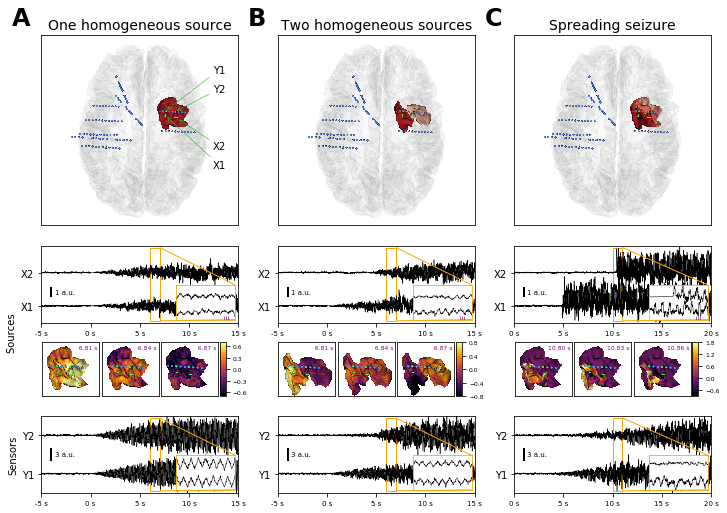

In [19]:
fig = plt.figure(figsize=(10, 7))
gs =  gridspec.GridSpec(4, 3, height_ratios=[2.5, 1, 0.7, 1])


# First row: glass brains
axes = []
for k, (label, img) in enumerate([("One homogeneous source", img_os),
                                  ("Two homogeneous sources", img_ts),
                                  ("Spreading seizure", img_ps)]):

    ax = plt.subplot(gs[0, k])
    axes.append(ax)
    plt.imshow(img, interpolation='none')
    plt.xticks([]); plt.yticks([]);
    plt.title(label, fontsize=14)
    
    if k == 0:
        coords = "axes fraction"
        ap = {'arrowstyle': '->', 'color': '#34B634', 'lw': 0.6}
        plt.annotate("Y1", (0.630, 0.600), (0.87, 0.8), xycoords=coords, textcoords=coords, arrowprops=ap)
        plt.annotate("Y2", (0.678, 0.595), (0.87, 0.7), xycoords=coords, textcoords=coords, arrowprops=ap)
        plt.annotate("X1", (0.630, 0.575), (0.87, 0.3), xycoords=coords, textcoords=coords, arrowprops=ap)
        plt.annotate("X2", (0.688, 0.560), (0.87, 0.4), xycoords=coords, textcoords=coords, arrowprops=ap)
        

# Second row: source signals ----------------------------------------------------------
xlims1 = [( 5, 25), ( 5, 25), (10, 30)]
xlims2 = [(16, 17), (16, 17), (20, 21)]

ylim = (-0.5, 1.8)
scaling = 100
for k, (simres, showsrcs) in enumerate([(simres_os, showsrcs_os), 
                                        (simres_ts, showsrcs_ts),
                                        (simres_ps, showsrcs_ps)]):
    axb = plt.subplot(gs[1, k])
    
    tmask = (simres.t >= xlims1[k][0]) * (simres.t < xlims1[k][1])
    for i, ind in enumerate(showsrcs):
        plt.plot(simres.t, simres.source[ind, :]/scaling + i, color='k', lw=0.5)    
    plt.xticks([5, 10, 15, 20, 25, 30], ["-5 s", "0 s", "5 s", "10 s", "15 s", "20 s"], fontsize=7);
    plt.yticks([0, 1], ["X1", "X2"]); 
    plt.xlim(xlims1[k])
    plt.ylim(ylim)
    if k == 0:
        plt.ylabel("Sources                               ")
        
    scale_bars(axb, (0.05, 0.4), sizey=src_unit/scaling, labely="1 a.u.", fontsize=7, barwidth=2, config="right")
        

    axb_in = inset_axes(axb, width="30%", height="45%", loc=4, borderpad=0.3)
    for i, ind in enumerate(showsrcs):
        plt.plot(simres.t, simres.source[ind, :]/scaling + i, color='k', lw=0.5)
    plt.xlim(xlims2[k])
    plt.ylim(ylim[0] + 0.05, ylim[1] - 0.05)
    plt.scatter(tsnaps[k], (ylim[0] + 0.05)*np.ones(len(tsnaps[k])), marker=2, color='purple',
                s=20, lw=0.6, clip_on=False)
    plt.xticks([]); plt.yticks([])
    for p in ['top', 'bottom', 'left', 'right']:
        axb_in.spines[p].set_color('orange')
    mark_inset(axb, axb_in, loc1=1, loc2=4, ec='orange', lw=1, zorder=-1)

    
# Third row: snapshots ---------------------------------------------------------------
for k, snapshots in enumerate([snapshots_os, snapshots_ts, snapshots_ps]):
    inner_gs = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=gs[2, k], wspace=0.03, hspace=0.0,
                                                width_ratios=[1, 1, 1, 0.1, 0.2])
    
    for i, img in enumerate(snapshots):
        axd = plt.subplot(inner_gs[0, i])
        plt.text(0.97, 0.96, f"{tsnaps[k][i]-10:5.2f} s", fontsize=6, ha='right', va='top',
                 transform=axd.transAxes, color='purple')
        plt.imshow(img, interpolation='none')
        plt.xticks([]); plt.yticks([])
    
    
    ax = plt.subplot(inner_gs[0, 3])
    cb = matplotlib.colorbar.ColorbarBase(ax, cmap=plt.get_cmap('inferno'), 
                                          norm=matplotlib.colors.Normalize(vmin=vlims[k][0], vmax=vlims[k][1]),
                                          orientation='vertical')
    ax.tick_params(labelsize=6)
    cb.locator = matplotlib.ticker.MaxNLocator(nbins=5)
    cb.update_ticks()    
    
# Fourth row: sensor signals ---------------------------------------------------------
ylim = (-0.5, 1.5)
scaling = 250.
for k, simres in enumerate([simres_os, simres_ts, simres_ps]):    
    axc = plt.subplot(gs[3, k])
    for i, ind in enumerate(showinds):    
        plt.plot(simres.t, simres.seeg[ind, :]/scaling + i, color='k', lw=0.5)
    plt.xticks([5, 10, 15, 20, 25, 30], ["-5 s", "0 s", "5 s", "10 s", "15 s", "20 s"], fontsize=7);
    plt.xlim(xlims1[k])
    plt.ylim(ylim)    
    plt.yticks([0, 1], ["Y1", "Y2"])
    if k == 0:
        plt.ylabel("Sensors")
        
    scale_bars(axc, (0.05, 0.5), sizey=90*1./scaling, labely="3 a.u.", fontsize=7, barwidth=2, config="right")

    axc_in = inset_axes(axc, width="30%", height="45%", loc=4, borderpad=0.3)
    for i, ind in enumerate(showinds):
        plt.plot(simres.t, simres.seeg[ind, :]/250. + i, color='k', lw=0.5)
    plt.xlim(xlims2[k])
    plt.ylim(ylim[0] + 0.05, ylim[1] - 0.05)
    plt.xticks([]); plt.yticks([])
    for p in ['top', 'bottom', 'left', 'right']:
        axc_in.spines[p].set_color('orange')
    mark_inset(axc, axc_in, loc1=1, loc2=4, ec='orange', lw=1, zorder=-1)

# ------------------------------------------------------------------------------------
    
plt.subplots_adjust(left=0.05, right=0.98, top=0.94, bottom=0.03, wspace=0.2, hspace=0.2)
add_panel_letters(fig, axes, xpos=-0.15, fontsize=24)
plt.savefig("figs/models.pdf")

In [15]:
for noise in [0, 1]:
    for model in ['onestat', 'twostat', 'propwaves']:
        conf = pd.read_pickle(f"../run/Taa/simulations/configs_{subject}_{model}_{noise}.pkl")
        print(f"{model:10s} {noise}: {conf.loc[0, 'snr_bg']:7.2f}")

onestat    0:   87.69
twostat    0:  113.89
propwaves  0:  368.08
onestat    1:   67.53
twostat    1:   86.24
propwaves  1:  290.04
